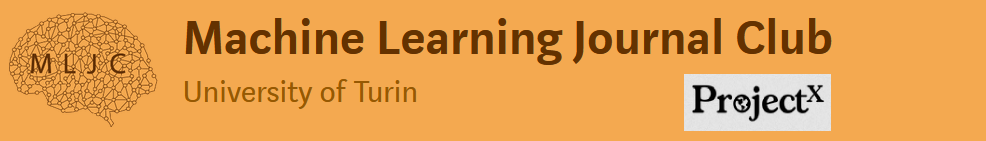

###ProjectX 2020 UofT AI Competition - File metadata

| Date created | Title | Type | Domain | Version |License / confidentiality
| --- | --- | --- | --- | --- | --- |
| 16-11-20 | Interpolation preprocessing | Preprocessing | WRF to Julia | 1.0 | Public |


Interpolation of discretized matrices of data from WRF to continuous fields for NeuralPDE

In [ ]:
import numpy as np
import scipy as sci
from matplotlib import pyplot as plt
import skimage
from skimage import transform
from scipy.interpolate import griddata
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D

### Interp2D

In [ ]:
#Let's create a dummy 2D array (import here your data)
def f(x,y):
  return (x*x + np.cos(y))

f = np.vectorize(f)

#import here your data
xmin, xmax = -4., 4. #1D array, representing x scale
ymin, ymax = -4., 4. #1D array, representing y scale
xres_original = 100
yres_original = 100


xaxisDummy = np.linspace(xmin, xmax, xres_original)
yaxisDummy = np.linspace(ymin, ymax, yres_original)

dummy  = f(xaxisDummy[:,None], yaxisDummy[None,:])

xaxis = xaxisDummy
yaxis = yaxisDummy
data  = dummy      #2D array containing the data

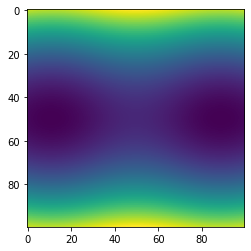

In [ ]:
plt.imshow(data)

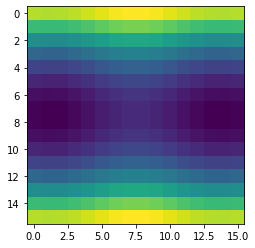

In [ ]:
#Array scaling with 'smooth' interpolation:
xres_scaled = 16
yres_scaled = 16
scaled1 = skimage.transform.resize(data, (xres_scaled, yres_scaled))
plt.imshow(scaled1)

In [ ]:
xaxisS = np.linspace(xmin, xmax, xres_scaled)
yaxisS = np.linspace(ymin, ymax, yres_scaled)

intp = sci.interpolate.interp2d(xaxisS, yaxisS, scaled1, kind='cubic', copy=True, bounds_error=False, fill_value=None)

### SciPy curve_fit

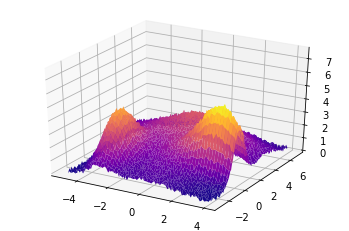

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Fitted parameters:
[ 2.99224275e+00  4.74618337e-01  1.91565054e+00  9.24741530e-01
  4.64531016e+00 -3.52915641e-01  3.26528590e+00  4.08742336e+00
  4.12177853e+00  2.85584048e+00 -2.98872281e+00 -7.14911632e-01
 -8.94007840e-01  1.80418024e+00  3.67749804e+00  8.69444755e+02
 -1.30629700e+01  2.98326394e+02  8.19210263e-01 -2.66849817e+02]
RMS = 0.18727930580153757


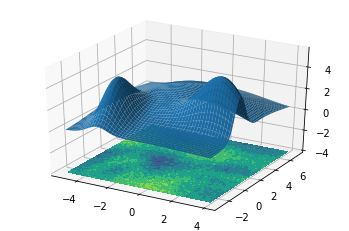

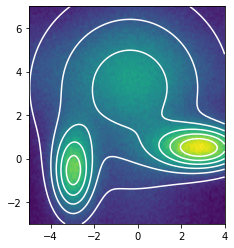

In [ ]:
x, y = np.linspace(xmin, xmax, xres_original), np.linspace(ymin, ymax, yres_original)
X, Y = np.meshgrid(x, y)

# 2 gaussians
def gaussian(x, y, x0, y0, xalpha, yalpha, A):
    return A * np.exp( -((x-x0)/xalpha)**2 -((y-y0)/yalpha)**2)

# A list of the Gaussian parameters: x0, y0, xalpha, yalpha, A
gprms = [(0, 2, 2.5, 5.4, 1.5),
         (-1, 4, 6, 2.5, 1.8),
         (-3, -0.5, 1, 2, 4),
         (3, 0.5, 2, 1, 5)
        ]

# Standard deviation of normally-distributed noise to add in generating
# our test function to fit.
noise_sigma = 0.1

Z = np.zeros(X.shape)
for p in gprms:
    Z += gaussian(X, Y, *p)
Z += noise_sigma * np.random.randn(*Z.shape)

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, Z, cmap='plasma')
ax.set_zlim(0,np.max(Z)+2)
plt.show()

def _gaussian(M, *args):
    x, y = M
    arr = np.zeros(x.shape)
    for i in range(len(args)//5):
       arr += gaussian(x, y, *args[i*5:i*5+5])
    return arr


g_param = [(0, 1, 1, 1, 5), (-1.5, 5, 6, 1, 3), (-4, -1, 1.5, 1.5, 7), (6, 1, 1.5, 1.9, 6.5)]

p0 = [p for prms in g_param for p in prms]

xdata = np.vstack((X.ravel(), Y.ravel()))
parr, paramCovar = curve_fit(_gaussian, xdata, Z.ravel(), p0)
fit = np.zeros(Z.shape)
for i in range(len(parr)//5):
    fit += gaussian(X, Y, *parr[i*5:i*5+5])
print('Fitted parameters:')
print(parr)

rms = np.sqrt(np.mean((Z - fit)**2))
print('RMS =', rms)

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, fit,)
cset = ax.contourf(X, Y, Z-fit, zdir='z', offset=-4,)
ax.set_zlim(-4,np.max(fit))
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(Z, origin='bottom',
          extent=(x.min(), x.max(), y.min(), y.max()))
ax.contour(X, Y, fit, colors='w')
plt.show()

### C++ CERN ROOT FIT TOOLS

In [ ]:
//Please run using CERN ROOT 6

#include <stdio.h>
#include <stdlib.h>
#include <iostream>
#include <vector>

double fexample(double x, double y) {
        return x*x + y*y +x;
    }

void Surface_fit()
{
    std::vector<double> xaxis;
    std::vector<double> yaxis;

    int xresolution = 20;
    int yresolution = 20;
    double xlo = -3.;
    double xhi = 3.0;
    double ylo = -3.;
    double yhi = 3.0;

    //Creating linspaces
    for (double l = xlo; l < xhi; l = l + ((xhi-xlo)/xresolution)) {
        xaxis.push_back(l);
    }

    for (double l = ylo; l < yhi; l = l + ((yhi-ylo)/yresolution)) {
        yaxis.push_back(l);
    }

    //Create the TH2D object:
    TH2D * h2 = new TH2D("h2", "Interpolation", xresolution, xlo, xhi, yresolution, ylo, yhi);

    //Generate example data, replace the following lines with the import commands
    for (int i = 0; i < xaxis.size(); ++i)
    {
        for (int j = 0; j < yaxis.size(); ++j) 
        {
            Int_t binx = h2->GetXaxis()->FindBin(xaxis[i]);
            Int_t biny = h2->GetXaxis()->FindBin(yaxis[j]);
            h2->SetBinContent(binx, biny, fexample(xaxis[i], yaxis[j]));
            std::cout << "\nFilling in \t" << xaxis[i] << " \t" << xaxis[j] << "\t value \t" << fexample(xaxis[i], yaxis[j]);
        }
    }

    //Try to fit with 2 deg poly
    TF2 *f2 = new TF2("f2","[0] + [1]*x + [2]*y + [3]*x*x + [4]*y*y",0,5,0,5);
    f2->SetParameters(0., 2, 2, 2, 2);
    h2->Fit(f2);

    cout << "\nThe symbolic intrpolation is \n" << "z=" <<
         f2->GetFormula()->GetExpFormula() << "\nWith parameters listed above\n\n";
    
    h2->Draw("lego2");

}

#### References:
1. Scipy, Sympy, Numpy docs
2. https://www.unioviedo.es/compnum/labs/PYTHON/Interpolation.html
3. https://gist.github.com/melpomene/2482930
4. http://evoq-eval.siam.org/Portals/0/Publications/SIURO/Vol1_Issue1/A_Simple_Expression_for_Multivariate.pdf?ver=2018-03-30-130233-050
5. https://scipython.com/blog/non-linear-least-squares-fitting-of-a-two-dimensional-data/